### Import data set and relevant libraries.

In [1]:
import pandas as pd
import numpy as np
# DataFrame
data = pd.read_csv("new-spotify-2023.csv")
# array
ar_data = np.array(data)

In [2]:
# plotting library
import seaborn as sns
# plotting customization
import matplotlib.pyplot as plt
# extra statistical functions
import statistics as st

### Check for null values and sanitize data.

In [3]:
pd.isnull(data).sum()

track_name               0
artist(s)_name           0
artist_count             0
released_year            0
released_month           0
released_day             0
in_spotify_playlists     0
in_spotify_charts        0
streams                  0
in_apple_playlists       0
in_apple_charts          0
in_deezer_playlists      0
in_deezer_charts         0
in_shazam_charts        50
bpm                      0
key                     95
mode                     0
danceability_%           0
valence_%                0
energy_%                 0
acousticness_%           0
instrumentalness_%       0
liveness_%               0
speechiness_%            0
dtype: int64

#### **Initially:**
"in_shazam_charts" = 50 

"key"             = 95

Knowing that there are 953 rows by 24 columns (22,872 values), 145 null values is a relatively low. The column "in_shazam_charts" will not be relevant to the analysis being done so those null values can be ignored. However the "key" column will be important and the null values will need to be addressed. 

**There are two options:** 

1. Remove all songs with null key values from the data set for analysis related to the key.

2. Determine the most common key and assign it to all 95 null values.


**Option 1 will be chosen.** Removing rows with null key values might result in a reduced sample size, but it prioritizes accuracy over quantity. It allows for a more precise examination of the relationship between key and other variables without introducing artificial values. Thankfully the data set is large enough that 95 is only  9.96% of the overall set.

#### Create a copy of the data set and remove all songs with null key values from it.

In [15]:
# copy original DataFrame into new DataFrame
noNullKey = data.copy()
# copy original DataFrame into new DataFrame - this one will retain songs with null key values
spotifyData = data.copy()
spotify = np.array(spotifyData)

# remove null values in new "noNullKey" DataFrame
noNullKey.dropna(subset=['key'], inplace=True)
# matrix version of DataFrame
NoNullKey_ar = np.array(noNullKey)

As for outliers - those will be left in. There is really only way for an outlier to exist in this data set - streams. However these high stream outliers don't skew the graphs a lot given the nature of the data set. Besides, leaving them in provides valuable insight on the characteristics of the most streamed song(s) compared to other popular songs. 

### 1. On average, which key of a song performs the best?

#### Count occurnaces of each key and store in a series.

In [8]:
# kc = key counts
# creates series - use .sort_index() to ensure data lines up with other series
kc = noNullKey['key'].value_counts().sort_index()
print(kc)

A      75
A#     57
B      81
C#    120
D      81
D#     33
E      62
F      89
F#     73
G      96
G#     91
Name: key, dtype: int64


#### Create a series where each key has the sum of streams of every song written in that key.

In [9]:
# group the DataFrame by the 'key' column using the groupby method
# select the 'streams' column from each group using ['streams']
# calculate the sum of 'streams' for each key group
# ks = key streams
ks = noNullKey.groupby('key')['streams'].sum()
print(ks)

key
A     30467520928
A#    31972869822
B     42067184540
C#    72513629843
D     42891570295
D#    18250205825
E     35804825731
F     41691728620
F#    38132510024
G     43449542493
G#    43398979639
Name: streams, dtype: int64


#### Calculate the average streams a song of a certain key gets. 

In [10]:
# create a series where total streams are divided by song count
meanByKey = pd.Series(
                 [ks[0]/kc[0], 
                  ks[1]/kc[1],
                  ks[2]/kc[2], 
                  ks[3]/kc[3],
                  ks[4]/kc[4], 
                  ks[5]/kc[5],
                  ks[6]/kc[6], 
                  ks[7]/kc[7], 
                  ks[8]/kc[8], 
                  ks[9]/kc[9], 
                  ks[10]/kc[10]],  
                 index=("A","A#","B","C#","D","D#","E","F","F#","G","G#"));

# convert series into DataFrame to be used for graphing
meanDataFrame = pd.DataFrame({'key':meanByKey.index, 'streams':meanByKey.values})
print(meanDataFrame)

   key       streams
0    A  4.062336e+08
1   A#  5.609275e+08
2    B  5.193480e+08
3   C#  6.042802e+08
4    D  5.295256e+08
5   D#  5.530365e+08
6    E  5.774972e+08
7    F  4.684464e+08
8   F#  5.223632e+08
9    G  4.525994e+08
10  G#  4.769119e+08


#### Create the graph.

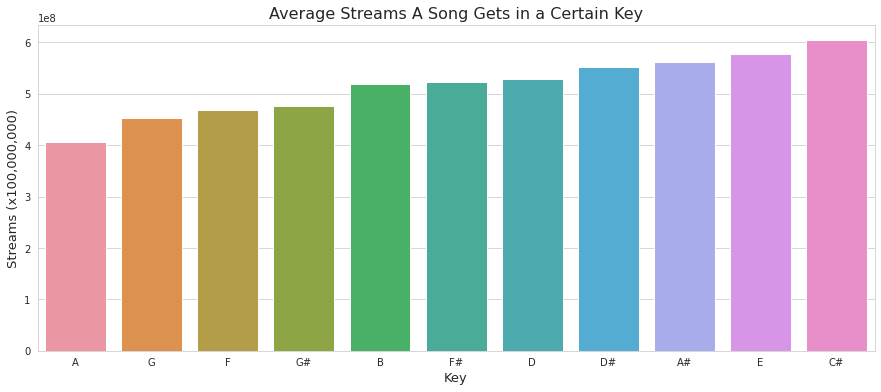

In [11]:
sns.set_style("whitegrid")
plt.figure(figsize = (15, 6))
sns.barplot(x = 'key', 
            y = 'streams', data = meanDataFrame,
            # order the graph from least to greatest
            order = meanDataFrame.sort_values('streams').key)
plt.xlabel('Key').set_fontsize('13')
plt.ylabel('Streams (x100,000,000)').set_fontsize('13')
plt.title('Average Streams A Song Gets in a Certain Key').set_fontsize('16')

#### 1. Summary:

Overall the data distribution has a small to medium variation with a gradual incline.

1. Songs written in the key of "C#" (the most popular key to write a song in) have the highest average streams. One could infer that Western countries prefer songs written in C# fom this finding (as 80% of Spotify listeners live in Western countries). There is one concern: Are artists influencing this? Since most songs are written in C# there is a higher chance for a "hit" song to be released in C#. However the second point in this summary counters this point.

2. Songs written in the key of "D#" which make up only 3.4% of songs in this data set have the fourth highest average streams. Even though few songs are written in D# the ones that do peform very well.

3. Songs written in the key of "A" have the lowest average streams yet are the median value in occurance of songs written in a certain key.


### 2. Is there a time of year when the most streamed songs are released?

#### Take the month and day a song was released and calculate the exact day in the year it was released (out of 365).

In [16]:
# function to take the month and day a song was released and get the exact day in the year
def getDayInYear(months, days):
    days_in_month = [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
    total_days = sum(days_in_month[:months]) + days
    return total_days

# create an array of data with int values from the 5th column in the data set
months = spotify[:,4].astype(int)
# create an array of data with int values from the 6th column in the data set
days = spotify[:,5].astype(int)
# create an empty array that will be filled by the getDayInYear function
daysInYear = np.zeros_like(months)

# fill daysInYear array with the exact day out of the 365 days in a year that a song was released
for i in range(len(months)):
    daysInYear[i] = getDayInYear(months[i],days[i])

# verify the arrays were populated correctly
print(len(months))
print(len(daysInYear))

953
953


#### Create an array where each value is the amount of streams a song got.
Each index in this array alligns with it's corresponding song in the daysInYear array.

In [17]:
streams = ar_data[:,8].astype(int)

# veryify the array was populated correctly
print(len(streams))

953


#### Create the graph.

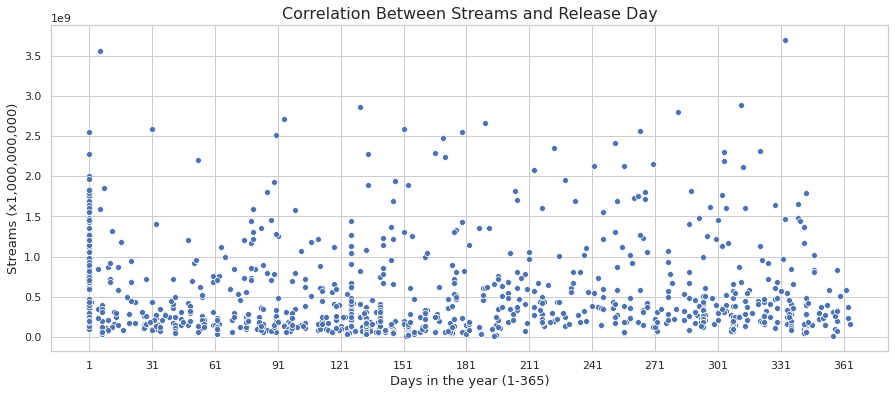

In [18]:
sns.set(style = "whitegrid")
plt.figure(figsize = (15, 6))
sns.scatterplot(x = daysInYear, y = streams)
plt.title("Correlation Between Streams and Release Day").set_fontsize('16')
plt.xlabel("Days in the year (1-365)").set_fontsize('13')
plt.ylabel("Streams (x1,000,000,000)").set_fontsize('13')
plt.xticks(range(1, 365, 30))
plt.show()

#### 2. Summary

Overall the data distribution has a large  variation. Because of this there isn't a clear time when the most successful songs are released. There are only two spots that stand out as slightly abnormal. 

1. Between days 1-61 there's a high density of songs released on the 1st day of the year then until day 61 there are few songs released that exceed 1,000,000,000 streams.
2. Around day 320 there is a gradual decline in songs with high streams until around day 345 when no songs exceed 1,000,000,000 streams. What could be happening is artists/record labels don't want to release songs at the end of the year as they will have less time to produce high numbers in the scope of a year. This theory is further backed by the previously mentioned large amount of songs released on the very first day of the year.

### 3. When are the most energetic songs released?
Each song is given a rating bewteen 9% and 97% for it's energy level. Higher is more energetic.

The previosuly generated daysInYear array will be used to help answer this.

#### Create an array where each value is the energy rating a song got
Each index in the energy array alligns with it's corresponding song in the daysInYear array.

In [19]:
energy = ar_data[:,19].astype(int)

# verify the array was populated correctly
print(len(energy))

953


#### Create the graph.

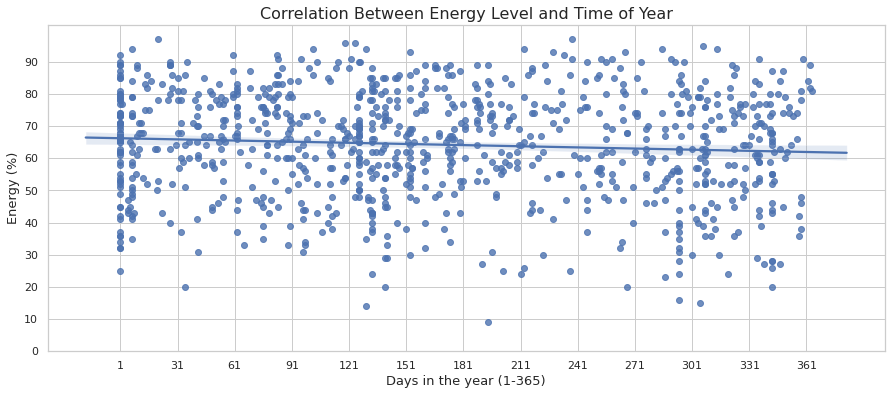

In [20]:
sns.set(style = "whitegrid")
plt.figure(figsize = (15, 6))
sns.regplot(x = daysInYear, y = energy)
plt.title("Correlation Between Energy Level and Time of Year").set_fontsize('16')
plt.xlabel("Days in the year (1-365)").set_fontsize('13')
plt.ylabel("Energy (%)").set_fontsize('13')
plt.xticks(range(1, 365, 30))
plt.yticks(range(0, 100, 10))
plt.show()

#### 3. Summary

Surprisingly there is almost no correlation between the time of year a song is released and the energy level of the song. It was hypothesized that songs released during the spring and summer would have a higher energy level and songs during the fall and winter time would have a lower energy level. 

To squeeze out as much information as possible regression plot was made that features a line of best fit. The line starts around 66%-67% and by the end of the year is at 61%-62% suggesting that as the year goes on songs get slightly less energetic. However, considering the margin for error and already tiny difference over such a large amount of time it must be stressed that this correlation is almost non-existent.

### 4. Is there a correlation between a songs energy level and positivity?

This data set provides a cool piece of data for all of its songs: "Valence" - the positivity of a songs musical content. In other words how positive a song is.

The previosuly generated energy array will be used to help answer this.

#### Create an array with the valence rating.
Each index in the valence array alligns with its corresponding value in the energy array.

In [21]:
valence = ar_data[:,18].astype(int)

# Verify the array was populated correctly
print(len(valence))

953


#### Create the graph.

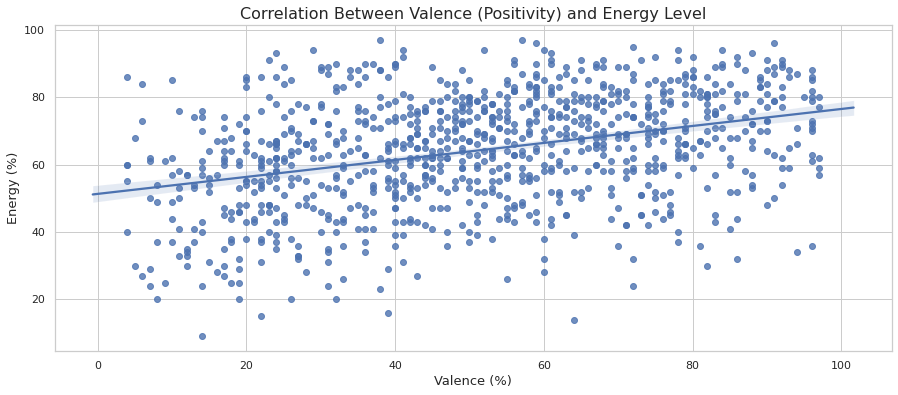

In [22]:
sns.set(style = "whitegrid")
plt.figure(figsize = (15, 6))
sns.regplot(x = valence, y = energy)
plt.title("Correlation Between Valence (Positivity) and Energy Level").set_fontsize('16')
plt.xlabel("Valence (%)").set_fontsize('13')
plt.ylabel("Energy (%)").set_fontsize('13')
plt.show()

#### 4. Summary

While the data distrubtion has a large variation, the line of best fit reveals a clear trend: 
1. As a song becomes more positive it generally becomes more energetic. The line of best fit begins at 51% and has a positive slope ending at around 77%

However this doesn't mean low valence songs can't be energetic. In fact there are a large amount of 9%-40% valence songs with energy ratings above 70%. Similarly, there are some high valence low energy outliers as well. 

In the context of music these outliers make a lot of sense given that songs lyrics don't always match the energy of the song.

